
# Bank Marketing Campaign Classification

Improved pipeline using one-hot encoding, stratified splits, and tuned gradient boosting to lift recall/F1 on the term deposit prediction.


## 1. Imports

In [21]:

from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    roc_auc_score,
)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

sns.set(style="whitegrid")


## 2. Load the Data

Load dataset from the datasets/ directory

In [ ]:

# Resolve project paths and organize outputs
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

DATA_DIR = PROJECT_ROOT / "datasets" / "bank-marketing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
for path in [OUTPUT_DIR, PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")


In [22]:

data_path = DATA_DIR / "bank-full.csv"
df = pd.read_csv(data_path, sep=";")
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]} columns from {data_path}")
print(df["y"].value_counts(normalize=True).rename("proportion"))


Loaded 45,211 rows and 17 columns
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64



## 3. Preprocessing

- Remove extreme outliers on a few numeric fields.
- Separate categorical vs numeric columns for proper encoding.
- Stratified train/test split to preserve class balance.


In [23]:

for col in ["balance", "age", "duration", "campaign"]:
    z_scores = np.abs(df[col] - df[col].mean()) / df[col].std()
    df = df[z_scores < 3]

print(f"After outlier filtering: {df.shape[0]:,} rows remain.")


After outlier filtering: 42,338 rows remain.


In [24]:

X = df.drop(columns="y")
y = df["y"].map({"yes": 1, "no": 0})

categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()
numeric_cols = [col for col in X.columns if col not in categorical_cols]

preprocess_template = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numeric", StandardScaler(with_mean=False), numeric_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"Positive class weight (train): {pos_weight:.2f}")
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Positive class weight (train): 8.58
Train size: 33870, Test size: 8468


### Helper functions

In [25]:

def find_best_threshold(probs, y_true, search=np.linspace(0.2, 0.8, 31)):
    scores = [(thr, f1_score(y_true, (probs >= thr).astype(int))) for thr in search]
    return max(scores, key=lambda x: x[1])

def evaluate(name, probs, y_true, threshold=None):
    if threshold is None:
        threshold, _ = find_best_threshold(probs, y_true)
    preds = (probs >= threshold).astype(int)
    print(f"{name} @ threshold {threshold:.2f}")
    print(f"  Accuracy: {accuracy_score(y_true, preds):.4f}")
    print(f"  F1: {f1_score(y_true, preds):.4f}")
    print(f"  Recall: {recall_score(y_true, preds):.4f}")
    print(f"  ROC AUC: {roc_auc_score(y_true, probs):.4f}")
    return preds, threshold


## 4. Logistic Regression (one-hot + class weights)

In [26]:

log_pipeline = Pipeline(
    steps=[
        ("preprocess", clone(preprocess_template)),
        ("model", LogisticRegression(max_iter=500, class_weight="balanced")),
    ]
)

log_pipeline.fit(X_train, y_train)
log_probs = log_pipeline.predict_proba(X_test)[:, 1]
log_preds, log_threshold = evaluate("Logistic Regression", log_probs, y_test)


Logistic Regression @ threshold 0.64
  Accuracy: 0.8782
  F1: 0.5519
  Recall: 0.7183
  ROC AUC: 0.9071


## 5. Tuned XGBoost (best current performer)

In [27]:

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=4,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.1,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=pos_weight,
    tree_method="hist",
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", clone(preprocess_template)),
        ("model", xgb_clf),
    ]
)

xgb_pipeline.fit(X_train, y_train)
xgb_probs = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_preds, xgb_threshold = evaluate("XGBoost (tuned)", xgb_probs, y_test)


XGBoost (tuned) @ threshold 0.72
  Accuracy: 0.9067
  F1: 0.6281
  Recall: 0.7545
  ROC AUC: 0.9378


## 6. Confusion Matrices

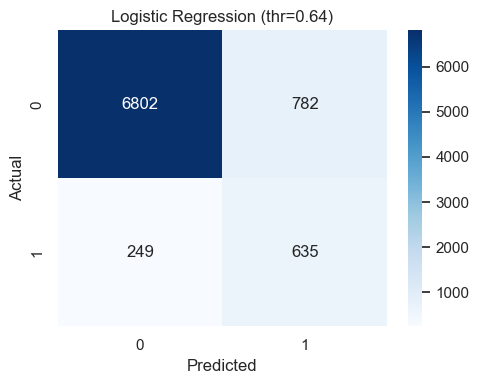

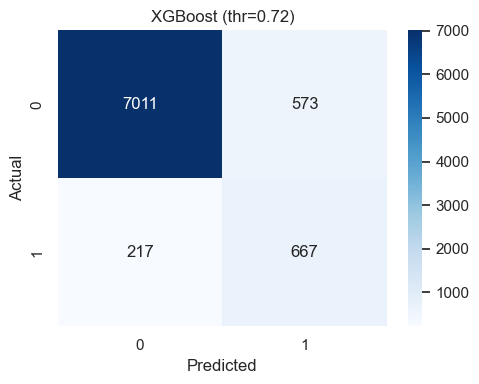

In [28]:

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    outfile = PLOTS_DIR / f"{title.replace(' ', '_').lower()}_confusion_matrix.png"
    plt.savefig(outfile)
    plt.show()
    print(f"Saved confusion matrix to {outfile}")

plot_confusion(y_test, log_preds, f"Logistic Regression (thr={log_threshold:.2f})")
plot_confusion(y_test, xgb_preds, f"XGBoost (thr={xgb_threshold:.2f})")


## 7. Persist Models

In [29]:

log_model_path = MODELS_DIR / "logistic_regression.pkl"
xgb_model_path = MODELS_DIR / "xgboost.pkl"
joblib.dump({"pipeline": log_pipeline, "threshold": log_threshold}, log_model_path)
joblib.dump({"pipeline": xgb_pipeline, "threshold": xgb_threshold}, xgb_model_path)
print(f"Saved logistic regression model to {log_model_path}")
print(f"Saved XGBoost model to {xgb_model_path}")


['xgboost.pkl']

## 8. Generate Predictions and Export

In [30]:

predictions_path = PREDICTIONS_DIR / "classification_predictions.csv"
pred_output.to_csv(predictions_path, index=False)
print(f"Saved predictions to {predictions_path}")


Saved predictions to classification_predictions.csv


## 9. Model Interpretability with SHAP

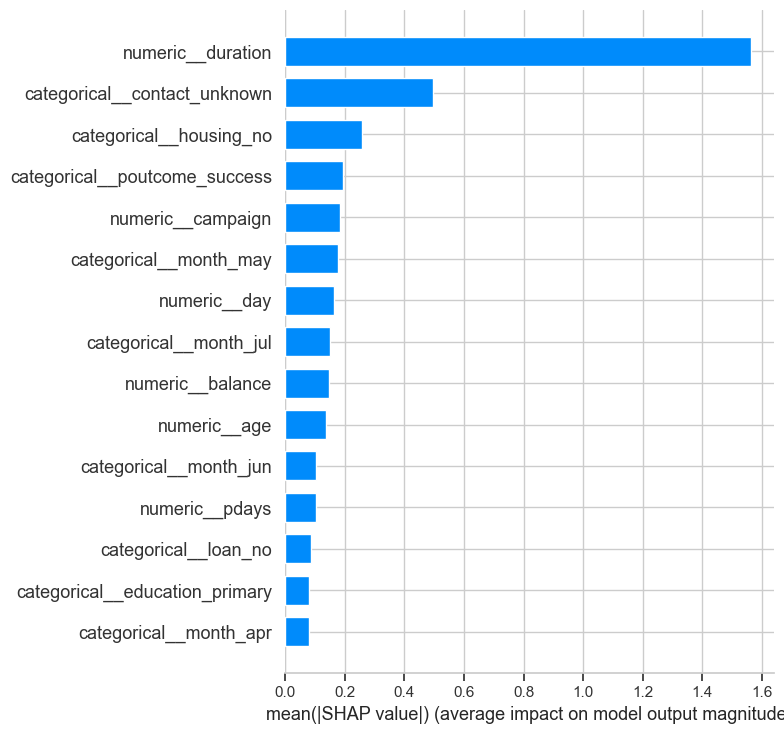

In [31]:

feature_names = xgb_pipeline.named_steps["preprocess"].get_feature_names_out()
X_test_encoded = xgb_pipeline.named_steps["preprocess"].transform(X_test)

sample_size = min(1000, X_test_encoded.shape[0])
sample_indices = np.random.RandomState(42).choice(
    X_test_encoded.shape[0], sample_size, replace=False
)
X_sample = X_test_encoded[sample_indices]

if hasattr(X_sample, "toarray"):
    X_sample = X_sample.toarray()

explainer = shap.TreeExplainer(xgb_pipeline.named_steps["model"])
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(
    shap_values,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15,
    show=False,
)
plt.tight_layout()
shap_plot_path = PLOTS_DIR / "xgboost_shap_summary_bar.png"
plt.savefig(shap_plot_path, bbox_inches="tight")
plt.close()
print(f"Saved SHAP summary plot to {shap_plot_path}")
